Plots for learning harmonic functions
with neural networks.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import dataclasses
import logging
import os
import sys
import warnings
from typing import Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from tqdm import tqdm

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch as t

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [66]:
sys.path.append("..")

import src.experiments.harmonics.bw_loss as bw_loss
from src.experiments.harmonics.data import HypercubeDataModule
from src.experiments.harmonics.harmonics import (
    HarmonicFn,
    HarmonicFnConfig,
)
from src.experiments.harmonics.poly import ChebPoly
from src import utils

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Utility code

In [4]:
def get_mse(
    model: pl.LightningModule,
    dl: t.utils.data.DataLoader,
) -> t.Tensor:
    return pl.Trainer(
        enable_progress_bar=False,
    ).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]['test_mse']


@dataclasses.dataclass(frozen=True)
class LSData:
    ns: np.ndarray
    val_mses: np.ndarray
    
    noise_std: float
    
def run_lstsq_exp(
    ns: list[int],
    true_fn: Union[HarmonicFn, ChebPoly],
    estimator: Callable[[np.ndarray, np.ndarray], pl.LightningModule],
    n_trials: int = 1,
    noise_std: float = 0.0,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        mses = []
        for trial_idx in range(n_trials):
            dm = HypercubeDataModule(
                fn=true_fn,
                input_dim=true_fn.cfg.input_dim,
                n_train=n_train,
                n_val=1024,
                train_seed=trial_idx,
                val_seed=-1,
                num_workers=0,
                batch_size=256,
            )
            dm.setup()

            xs_train = dm.train_ds.tensors[0].numpy()
            ys_train = dm.train_ds.tensors[1].numpy()
            
            fn_hat = estimator(
                xs_train,
                ys_train + noise_std * np.random.normal(size=len(ys_train)),
            )

            mse = get_mse(model=fn_hat, dl=dm.val_dataloader())
            mses.append(mse)
        
        val_mses.append(mses)
    
    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
        noise_std=noise_std,
    )

## Run experiments

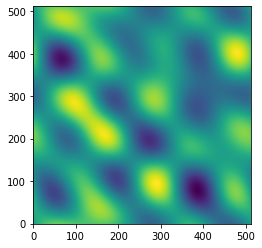

In [5]:
TRUE_HF = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=3,
        num_components=16,
    )
)
TRUE_HF.viz_2d(side_samples=512, pad=(0, 0));

In [106]:
dm = HypercubeDataModule(
    fn=TRUE_HF,
    input_dim=TRUE_HF.cfg.input_dim,
    n_train=300,
    n_val=1024,
    train_seed=-1,
    val_seed=100,
    num_workers=0,
    batch_size=256,
)
dm.setup()

xs_train: np.ndarray = dm.train_ds.tensors[0].numpy().astype(np.float64)
ys_train: np.ndarray = dm.train_ds.tensors[1].numpy().astype(np.float64)

fn_hat = ChebPoly.construct_via_lstsq(
    xs=xs_train,
    ys=ys_train,
    deg_limit=16,
    freq_limit=3,
    hf_lambda=1e-1,
    n_reg_samples=10_000,
)

print("Train MSE:", get_mse(model=fn_hat, dl=dm.train_dataloader(shuffle=False)))
print("Test MSE:", get_mse(model=fn_hat, dl=dm.val_dataloader()))

print(
    "HF-norm (mcls):",
    bw_loss.high_freq_norm_mcls(
        fn=fn_hat,
        input_dim=fn_hat.cfg.input_dim,
        freq_limit=3,
        n_samples=10_000,
        device=fn_hat.device,
    ),
)
print(
    "HF-norm (dft): ",
    bw_loss.high_freq_norm_dft(
        fn=fn_hat,
        input_dim=fn_hat.cfg.input_dim,
        freq_limit=3,
        side_samples=512,
        device=fn_hat.device,
    ),
)


Train MSE: 2.451714919970982e-08
Test MSE: 8.286767183562915e-08
HF-norm (mcls): tensor(6.5128e-08)
HF-norm (dft):  tensor(6.2763e-08)


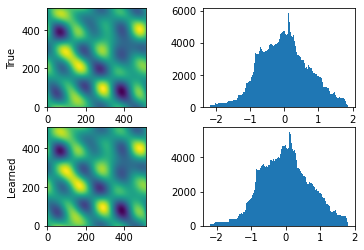

In [50]:
plt.subplot(2, 2, 1)
img = TRUE_HF.viz_2d(side_samples=512, pad=(0, 0), value=0.42)
plt.ylabel("True");

plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128)

plt.subplot(2, 2, 3)
img = fn_hat.viz_2d(side_samples=512, pad=(0, 0), value=0.42)
plt.ylabel("Learned");

plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

### Scaled up experiments

In [51]:
DATA = dict()

In [52]:
DATA["hf2"] = run_lstsq_exp(
    ns=list(range(1, 100)) + [200, 400, 800],
    true_fn=TRUE_HF,
    estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
        xs=xs,
        ys=ys,
        freq_limit=3,
    ),
)

100%|██████████| 102/102 [00:04<00:00, 23.12it/s]


In [107]:
for lam_str in ["0", "1e-2", "1", "10"]:
    DATA[f"cp12-f3-lam-{lam_str}"] = run_lstsq_exp(
        ns=list(range(1, 100)) + list(range(100, 5000, 50)) + list(range(5000, 20000, 1000)),
        true_fn=TRUE_HF,
        estimator=lambda xs, ys: ChebPoly.construct_via_lstsq(
            xs=xs,
            ys=ys,
            deg_limit=12,
            freq_limit=3,
            hf_lambda=float(lam_str),
            n_reg_samples=10_000,
        ),
        n_trials=1,
    )

100%|██████████| 212/212 [02:22<00:00,  1.48it/s]


In [108]:
for lam_str in ["0", "1e-2", "1", "10"]:
    DATA[f"cp16-f3-lam-{lam_str}"] = run_lstsq_exp(
        ns=list(range(1, 100)) + list(range(100, 5000, 50)) + list(range(5000, 20000, 1000)),
        true_fn=TRUE_HF,
        estimator=lambda xs, ys: ChebPoly.construct_via_lstsq(
            xs=xs,
            ys=ys,
            deg_limit=16,
            freq_limit=3,
            hf_lambda=float(lam_str),
            n_reg_samples=10_000,
        ),
        n_trials=1,
    )

100%|██████████| 212/212 [02:29<00:00,  1.42it/s]


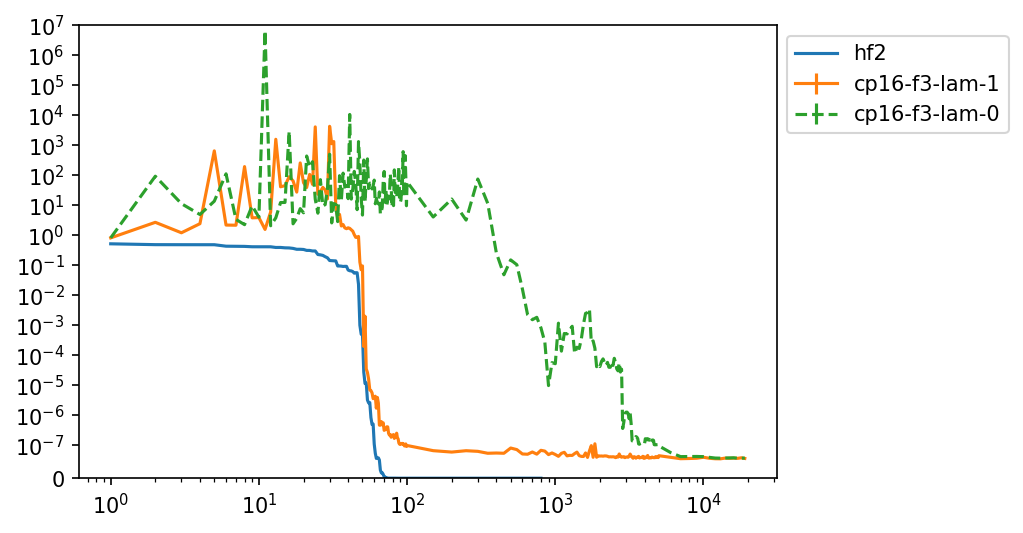

In [113]:
plt.figure(dpi=150)

plt.plot(DATA["hf2"].ns, DATA["hf2"].val_mses, label="hf2")

def plot_key(key: str, **plt_kwargs):
    utils.plot_errorbar(
        xs=DATA[key].ns, ys=DATA[key].val_mses,
        lo_q=0.5, mid_q=0.5, hi_q=0.5, label=key, **plt_kwargs
    )

plot_key("cp16-f3-lam-1")
plot_key("cp16-f3-lam-0", linestyle="--")
#plot_key("cp16-f3-lam-1e-2")

#plot_key("cp16-f3-lam-10")
# plot_key("cp16-f3-lam-1e2")

#plot_key("cp12-f3-lam-0")
#plot_key("cp12-f3-lam-1e-2")
#plot_key("cp12-f3-lam-1")

plt.xscale("log");
plt.yscale("symlog", linthresh=1e-7); plt.ylim(0, 1e7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));